# Instrument Recognition
*Matthew Greenlees and Nerea Tascon Ruiz*

In this notebook, we have implemented an instrument recognition algorithm based on a [paper](http://mtg.upf.edu/system/files/publications/smc-2016.pdf) from the Music Technology Group at Universitat Pompeu Fabra (UPF). The algorithm works by extracting a collection of low-level descriptors of a sound, then deriving some statistics based on these features, such as the mean of the zero crossing. These statistics are then normalised, and we use chi-squared feature selection to pick the most relevant. After that, we train and test a support vector machine (SVM) with 10-fold cross-validation, and plot the confusion matrix.

We investigate using only the MFCCs as features, as proposed by this [paper](https://www.researchgate.net/publication/327896931_Musical_Instrument_Recognition_using_Mel-Frequency_Cepstral_Coefficients_and_Learning_Vector_Quantization). We also look at the effects of training *without* stratified cross-validation.

For this task, we used part of the [Goodsounds](https://www.upf.edu/web/mtg/good-sounds) dataset to train and test our model on, as well as [Essentia](https://essentia.upf.edu/documentation/) for feature extraction and [Ski-kit Learn](https://scikit-learn.org/stable/) for the SVM. For this notebook to run, you will need to place it in the same directory as the Goodsounds dataset. In particular, you will need to place it in the same directory as the folder `sounds`. Within `sounds`, there must be folders whose names are the instrument labels. For example, within `sounds` we could have two folders named `bass` and `violin`. Within each of these folders, you must place the `.wav` files for each of the instruments.

This notebook is part of a submission for the Music Information Retrieval course on Sound and Music Computing Masters at UPF.

We begin by importing all the required packages.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import IPython

from essentia.standard import *
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn import svm

We set the random seed so that our results are reproducable.

In [2]:
np.random.seed(1)

The following code creates a list `sound_paths` of relative paths to the audio files. There are some instruments which has much more sounds than others. For example, there are 32 sounds for the cello, but 388 sounds for the piccolo. To address this, we randomly selected 30 sounds from each file.

In [3]:
# an object that will allow us to iterate over the files in ./sounds
gen = os.walk('./sounds')

# a list 
sound_paths = [(a, b, list(np.random.choice(c, size = 30, replace = False))) for a, b, c in os.walk('./sounds') if not b]
sound_paths = [os.path.join(a, x) for (a, b, c) in sound_paths for x in c]

# create a list of the class names, which are the names of the folders in ./sounds
for _, b, c in gen:
    if b:
        classes = b

Lets listen to one of the samples to see what they sound like.

In [4]:
test_sound = sound_paths[0]
IPython.display.Audio(sound_paths[0])

We use Essentia for feature extraction, we extract the features listed below.
- zero crossing rate
- spectral energy
- spectral rms
- mfcc rate
- lpc coef
- spectral centroid 
- spectral kurtosis
- spectral spread 
- spectral skewness
- spectral dissonance
- spectral contrast coefficients
- spectral valleys
- spectral decrease
- spectral hfc
- spectral flux
- spectral roll off
- spectral strong peak
- barkbands
- spectral crest
- spectral flatness
- barkbands central moments
- spectral complexity
- pitch confidence
- pitch salience

We have written a function `extract_features` that takes in a sample and returns a pool (an object from Essentia) of features.

For each sample, we split it into frames of size 46 ms (1024 samples) with a hop size of 24 ms (512 samples), then window the frame with a Blackman-Harris window.

Once we have extracted these features, we save them into a pool, and then use Essentia to calculate the mean, variance, mean of the derivative, and variance of the derivative of each of the features over all the frames.

In [5]:
def extract_features(audio):
    """Takes as input a numpy array representing the audio file, returns a pool of feature stats."""
    
    pool = essentia.Pool()
    frames = FrameGenerator(audio, frameSize = 1024, hopSize = 512, startFromZero = True)
    
    # create relevant function objects
    zcr = ZeroCrossingRate()
    w = Windowing(type = 'blackmanharris62')
    spectrum = Spectrum()
    energy = Energy()
    rms = RMS()
    centroid = Centroid()
    rolloff = RollOff()
    flux = Flux()
    hfc = HFC()
    spectral_complexity = SpectralComplexity()
    distribution_shape = DistributionShape()
    central_moments = CentralMoments()
    mfcc = MFCC()
    lpc = LPC()
    pitch_yin = PitchYinFFT()
    pitch_salience = PitchSalience()
    spectral_peaks = SpectralPeaks()
    dissonance = Dissonance()
    spectral_contrast_algo = SpectralContrast(frameSize = 1024, sampleRate = 44100)
    crest = Crest()
    strong_peak = StrongPeak()
    barkbands_algo = BarkBands()
    decrease = Decrease()
    flatness = FlatnessDB()
    
    for frame in frames:
        spec = spectrum(w(frame))
        cm = central_moments(spec)
        spread, skewness, kurtosis = distribution_shape(cm)
        _, pitch_confidence = pitch_yin(spec)
        frequencies, magnitudes = spectral_peaks(spec)
        _, mfccs = mfcc(spec)
        spectral_contrast, spectral_valley = spectral_contrast_algo(spec)
        barkbands = barkbands_algo(spec)
        lpcs, _ = lpc(frame)
        
        pool.add('zcr', zcr(frame))
        pool.add('spectral_energy', energy(spec))
        pool.add('spectral_rms', rms(spec))
        pool.add('spectral_centroid', centroid(spec))
        pool.add('spectral_rolloff', rolloff(spec))
        pool.add('spectral_flux', flux(spec))
        pool.add('spectral_hfc', hfc(spec))
        pool.add('spectral_spread', spread)
        pool.add('spectral_skewness', skewness)
        pool.add('spectral_kurtosis', kurtosis)
        pool.add('pitch_confidence', pitch_confidence)
        pool.add('pitch_salience', pitch_salience(spec))
        pool.add('dissonance', dissonance(frequencies, magnitudes))
        pool.add('spectral_complexity', spectral_complexity(spec))
        pool.add('spectral_decrease', decrease(spec))
        pool.add('spectral_crest', crest(spec))
        pool.add('strong_peak', strong_peak(spec))
        pool.add('spectral_flatness', flatness(barkbands))
        
        for i, value in enumerate(mfccs):
            pool.add('mfcc' + str(i), value)
        
        for i, value in enumerate(barkbands):
            pool.add('barkbands' + str(i), value)
        
        for i, value in enumerate(central_moments(barkbands)):
            pool.add('barkbands_central_moments' + str(i), value)
        
        for i, value in enumerate(lpcs):
            pool.add('lpc' + str(i), value)
        
        for i, value in enumerate(spectral_contrast):
            pool.add('spectral_contrast' + str(i), value)
        
        for i, value in enumerate(spectral_valley):
            pool.add('spectral_valley' + str(i), value)
    
    # turn pool of features into a pool of feature stats
    aggrPool = PoolAggregator(defaultStats = ['mean', 'var', 'dmean', 'dvar'])(pool)
    
    return aggrPool

Before we do anything else, we need to make a few definitions. First, we define an empty $m \times n$ matrix $X$, where $m$ and $n$ are the number of audio samples and the number of features respectively. 

We also define an empty vector $\textbf{y}$ of size $m$. The rows of $X$ will contain the feature stats of each audio sample, and the corresponding element of $\textbf{y}$ will contain an integer representing the instrument.

In [6]:
# load in audio for d, just to allow us to get the number of features and a list of descriptor names
loader = MonoLoader(filename = test_sound)
audio = loader()

# extract the feature stats and save them as a pool d
d = extract_features(audio)

# convert the pool of feature stats into a list of tuples, where the firt element of the tuple is an integer
# and the second element is the descriptor name
descriptor_names = d.descriptorNames()
descriptor_names = [(i, descriptor_names[i]) for i in range(len(descriptor_names))]

# create variables for the number of features and the number of samples
num_features = len(descriptor_names)
num_samples = len(sound_paths)

# create a matrix X of features and a vector y of labels
X = np.zeros((num_samples, num_features))
y = np.zeros(num_samples, dtype = int)

# create a list containing the labels of the instruments, as well as a dictionary which will be useful later on
num_classes = len(classes)

labels = list(range(num_classes))
dict_of_classes = dict(zip(classes, labels))

We are now ready to do the feature extraction.

**Note**: this block takes a while to run.

In [7]:
for i in range(len(sound_paths)):
    path = sound_paths[i]
    loader = MonoLoader(filename = path)
    audio = loader()
    
    agg_pool = extract_features(audio)
    
    for j, descriptor in descriptor_names:
        X[i, j] = agg_pool[descriptor]

    for instrument in dict_of_classes:
        if instrument in path:
            y[i] = dict_of_classes[instrument]
            break

Next, we normalise the columns of $X$ so that all the values in $X$ are between 0 and 1. This attempts to give equal weighting to each of the features.

In [8]:
min_max_scaler = MinMaxScaler()
X_norm = min_max_scaler.fit_transform(X)

After that, we reduce the number of descriptors used with $\chi^2$ feature selection.

In [9]:
select_k_best = SelectKBest(chi2, k = 150)
X_reduced = select_k_best.fit_transform(X_norm, y)

# make a list of indices of the selected features and a list of tuples with the index and name of all
# of the selected features
indices = select_k_best.get_support(indices = True)
descriptor_names_new = [(i, descriptor_names[i][1]) for i in range(len(indices))]

We use a grid-search to find the best parameters for our model. 

In [10]:
cs = np.logspace(-3, 2, 6)
gammas = np.logspace(-3, 2, 6)
kernels = ['linear', 'rbf']
param_grid = {'C': cs, 'gamma' : gammas, 'kernel': kernels}
grid_search = GridSearchCV(svm.SVC(), param_grid, cv = 10)

grid_search.fit(X_reduced, y)
best_params = grid_search.best_params_

Create some empty vectors to store the average precision, recall and F1 scores for all the instruments, as well as an empty matrix to store all of the confusion matrices. 

In [24]:
avg_precision = np.zeros(num_classes)
avg_recall = np.zeros(num_classes)
avg_f1 = np.zeros(num_classes)
conf_matrix = np.zeros((num_classes, num_classes))

We now use 10-fold cross-validation to train and test the model.

In [25]:
num_cv = 10

# create iterator and svm classifier object
sk = StratifiedKFold(num_cv, random_state = 0, shuffle = True)
clf = svm.SVC(**best_params, decision_function_shape = "ovr")

for train_index, test_index in sk.split(X_reduced, y):
    X_train = X_reduced[train_index]
    y_train = y[train_index]
    X_test = X_reduced[test_index]
    y_test = y[test_index]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred, labels = labels)
    pr, re, fs, su = precision_recall_fscore_support(y_test, y_pred)
    
    avg_precision += pr
    avg_recall += re
    avg_f1 += fs
    conf_matrix += cm

avg_precision /= num_cv
avg_recall /= num_cv
avg_f1 /= num_cv

print('Overall average precision\n', sum(avg_precision) / num_classes)

print('Average precision\n', avg_precision)
print('Average recall\n', avg_recall)
print('Average F1 score\n', avg_f1)

overall average precision
 0.907727272727
Average precision
 [ 0.975       0.975       0.86666667  0.96666667  0.82833333  0.975       1.
  0.685       0.885       1.          0.82833333]
Average recall
 [ 1.          0.96666667  0.73333333  0.93333333  0.76666667  0.96666667
  0.8         0.93333333  0.76666667  0.93333333  0.76666667]
Average F1 score
 [ 0.98571429  0.96571429  0.78666667  0.94666667  0.74904762  0.96571429
  0.87        0.76571429  0.77214286  0.96        0.75904762]


The code below finds the average confusion matrix and then plots it. The code was provided by the Ski-kit learn website, as they do not have a function for plotting a confusion matrix. The original code can be found [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html).

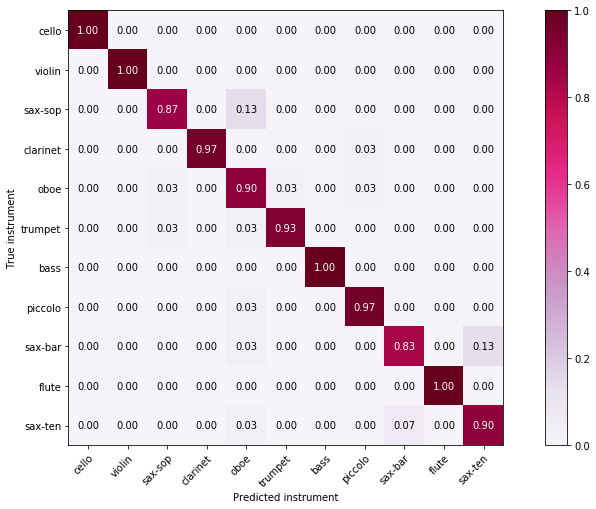

In [13]:
# find the average of the 10 confusion matrices
conf_matrix /= sum(conf_matrix[0, :])

fig, ax = plt.subplots(figsize = (15, 8))
im = ax.imshow(conf_matrix, interpolation = 'nearest', cmap = plt.cm.PuRd)
ax.figure.colorbar(im, ax = ax)

ax.set(xticks = np.arange(conf_matrix.shape[1]),
       yticks = np.arange(conf_matrix.shape[0]),
       xticklabels = classes,
       yticklabels = classes,
       ylabel = 'True instrument',
       xlabel = 'Predicted instrument')

plt.setp(ax.get_xticklabels(),
         rotation = 45,
         ha = "right",
         rotation_mode = "anchor")

fmt = '.2f'
thresh = conf_matrix.max() / 2

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(j, i, format(conf_matrix[i, j], fmt),
                ha = "center",
                va = "center",
                color = "white" if conf_matrix[i, j] > thresh else "black")

#fig.tight_layout()
plt.savefig('cm-1.pdf', bbox_inches = 'tight')
plt.savefig('cm-1.png', bbox_inches = 'tight', dpi = 500)

The code below just plots the average precision, recall and F1 score for every class of instrument.

In [26]:
print(np.column_stack((avg_precision, avg_recall, avg_f1)))
print(classes)
print(np.average(avg_precision), np.average(avg_recall), np.average(avg_f1))


[[ 0.975       1.          0.98571429]
 [ 0.975       0.96666667  0.96571429]
 [ 0.86666667  0.73333333  0.78666667]
 [ 0.96666667  0.93333333  0.94666667]
 [ 0.82833333  0.76666667  0.74904762]
 [ 0.975       0.96666667  0.96571429]
 [ 1.          0.8         0.87      ]
 [ 0.685       0.93333333  0.76571429]
 [ 0.885       0.76666667  0.77214286]
 [ 1.          0.93333333  0.96      ]
 [ 0.82833333  0.76666667  0.75904762]]
['cello', 'violin', 'sax-sop', 'clarinet', 'oboe', 'trumpet', 'bass', 'piccolo', 'sax-bar', 'flute', 'sax-ten']
0.907727272727 0.869696969697 0.866038961039


# MFCCs as features
In this section we try using only the MFCC means as our features.

We begin by creating a new matrix $X_{\text{mfcc}}$ that contains only the means of the MFCCs as the features.

In [15]:
mfcc_descriptors = [a for a, b in descriptor_names if a in range(176, 228) and b[-5 : ] == '.mean']
X_mfcc = X_norm[:, mfcc_descriptors]

Again, use a grid search to find the best parameters for the model.

In [16]:
grid_search.fit(X_mfcc, y)
best_params = grid_search.best_params_

Then we create empty arrays to record the results.

In [17]:
avg_precision = np.zeros(num_classes)
avg_recall = np.zeros(num_classes)
avg_f1 = np.zeros(num_classes)
conf_matrix = np.zeros((num_classes, num_classes))

Then we train the model. 

In [18]:
# create iterator and svm classifier object
sk = StratifiedKFold(num_cv, random_state = 0, shuffle = True)
clf = svm.SVC(**best_params, decision_function_shape = "ovr")

for train_index, test_index in sk.split(X_mfcc, y):
    X_train = X_mfcc[train_index]
    y_train = y[train_index]
    X_test = X_mfcc[test_index]
    y_test = y[test_index]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred, labels = labels)
    pr, re, fs, su = precision_recall_fscore_support(y_test, y_pred)
    
    avg_precision += pr
    avg_recall += re
    avg_f1 += fs
    conf_matrix += cm

avg_precision /= num_cv
avg_recall /= num_cv
avg_f1 /= num_cv

print('Overall average precision\n', sum(avg_precision) / num_classes)

print('Average precision\n', avg_precision)
print('Average recall\n', avg_recall)
print('Average F1 score\n', avg_f1)

overall average precision
 0.890108225108
Average precision
 [ 0.975       1.          0.75452381  0.885       0.79166667  0.825
  0.94166667  0.925       0.86666667  0.975       0.85166667]
Average recall
 [ 0.96666667  1.          0.8         0.73333333  0.73333333  0.83333333
  0.93333333  0.93333333  0.76666667  0.93333333  0.83333333]
Average F1 score
 [ 0.96571429  1.          0.71380952  0.75785714  0.73952381  0.81714286
  0.93238095  0.91714286  0.78809524  0.93571429  0.80880952]


Finally, we plot the confusion matrix. 

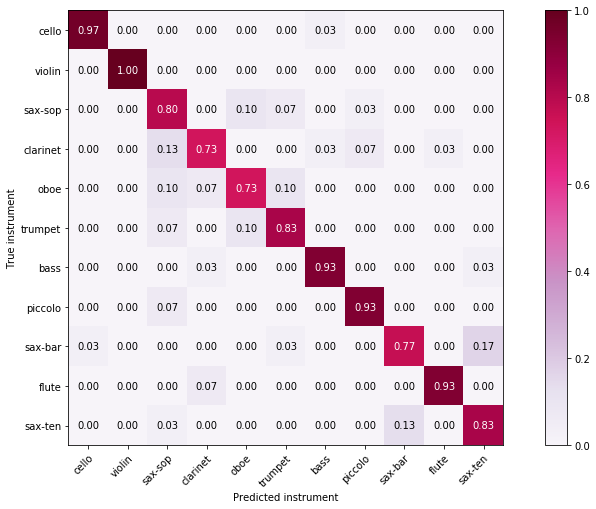

In [19]:

conf_matrix /= sum(conf_matrix[0, :])

fig, ax = plt.subplots(figsize = (15, 8))
im = ax.imshow(conf_matrix, interpolation = 'nearest', cmap = plt.cm.PuRd)
ax.figure.colorbar(im, ax = ax)

ax.set(xticks = np.arange(conf_matrix.shape[1]),
       yticks = np.arange(conf_matrix.shape[0]),
       xticklabels = classes,
       yticklabels = classes,
       ylabel = 'True instrument',
       xlabel = 'Predicted instrument')

plt.setp(ax.get_xticklabels(),
         rotation = 45,
         ha = "right",
         rotation_mode = "anchor")

fmt = '.2f'
thresh = conf_matrix.max() / 2

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(j, i, format(conf_matrix[i, j], fmt),
                ha = "center",
                va = "center",
                color = "white" if conf_matrix[i, j] > thresh else "black")

#fig.tight_layout()
plt.savefig('cm-2.pdf', bbox_inches = 'tight')
plt.savefig('cm-2.png', bbox_inches = 'tight', dpi = 500)

# Running the model without stratified cross-validation
In this section, we investigate what happens when we use regular cross-validation instead of stratified cross-validation.

In [20]:
conf_matrix = np.zeros((num_classes, num_classes))

# create iterator and svm classifier object
kf= KFold(num_cv, random_state = 0, shuffle = True)
clf = svm.SVC(**best_params, decision_function_shape = "ovr")

for train_index, test_index in kf.split(X_reduced):
    X_train = X_reduced[train_index]
    y_train = y[train_index]
    X_test = X_reduced[test_index]
    y_test = y[test_index]
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred, labels = labels)

    conf_matrix += cm

We now plot the confusion matrix. 

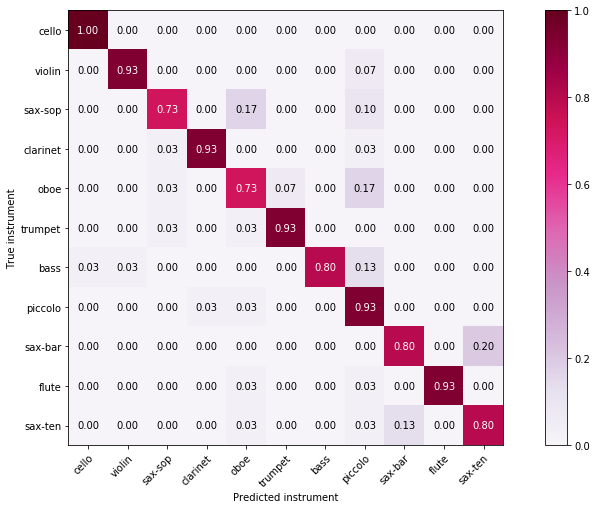

In [21]:
conf_matrix /= sum(conf_matrix[0, :])

fig, ax = plt.subplots(figsize = (15, 8))
im = ax.imshow(conf_matrix, interpolation = 'nearest', cmap = plt.cm.PuRd)
ax.figure.colorbar(im, ax = ax)

ax.set(xticks = np.arange(conf_matrix.shape[1]),
       yticks = np.arange(conf_matrix.shape[0]),
       xticklabels = classes,
       yticklabels = classes,
       ylabel = 'True instrument',
       xlabel = 'Predicted instrument')

plt.setp(ax.get_xticklabels(),
         rotation = 45,
         ha = "right",
         rotation_mode = "anchor")

fmt = '.2f'
thresh = conf_matrix.max() / 2

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(j, i, format(conf_matrix[i, j], fmt),
                ha = "center",
                va = "center",
                color = "white" if conf_matrix[i, j] > thresh else "black")

#fig.tight_layout()
plt.savefig('cm-3.pdf', bbox_inches = 'tight')
plt.savefig('cm-3.png', bbox_inches = 'tight', dpi = 500)